# Plan and Execute Agent

## Import

In [1]:
import os
from dotenv import load_dotenv

# define Actor Agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# define Planner Agent
from pydantic import BaseModel, Field
from typing import List
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage
)

# define RePlanner Agent
from typing import Union

# define Graph
from typing import Annotated, Tuple
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import add

## Environment Vairables

In [2]:
load_dotenv(os.path.join("..", "..", "config", ".env"))

True

## Implements

### Step 1 : Actor Agent

> ReAct 프롬프트 기반으로 동작하는 Agent에 'TavilyAI' 웹 검색 도구를 바인딩하여 계획에 따른 행동을 이행하는 Agent

`create_react_agent()` : ReAct Agent를 생성해주는 사전 구축 함수

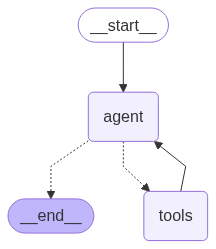

In [3]:
# define tools
search_tool = TavilySearchResults(
    max_results = 5,
    search_depth="advanced"
)
tools = [search_tool]

# define react agent
system_prompt = """
당신은 유능한 조력자 입니다. 한국어를 사용해 답변해주세요.
"""
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
actor = create_react_agent(
    model=llm,
    tools=tools,
    prompt=system_prompt
)

actor

### Step 2 : Planner Agent

> 사용자의 요청을 완수할 수 있는 일련의 행동 계획을 생성하는 Agent

In [4]:
# define llm response schema (plan)
class PlanSchema(BaseModel):
    """
    사용자 요청에 답변하기 위해 수립된 계획을 반환하기 위해 이 답변구조를 사용하세요.
    """
    steps: List[str] = Field(
        description="사용자의 요청을 완수하기 위한 일련의 계획 리스트, 반드시 실행 순서대로 작성되어야 한다."
    )

# define planner agent
planning_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(
        content="""
주어진 사용자 요청에 답변하기 위해 수행해야할 단계별 계획을 수립하세요.
이 계획상의 각 단계는 수행해야할 과업을 포함해야하며, 모든 단계를 수행하였을 때 사용자의 요청에 대한 답변이 가능해야합니다.
불필요한 단계는 포함시키지 마세요.
한국어를 사용하세요.
"""
    ),
    MessagesPlaceholder(variable_name="planing_request")
])
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.8
)
llm_with_planschema_output = llm.with_structured_output(PlanSchema)
planner_chain = planning_prompt | llm_with_planschema_output

### Step 3 : Re-Planner Agent

> 계획에 따라 수행한 Actor의 수행 결과를 확인하고, 계획을 수정하거나, 더 진행하지 않고 답변을 내놓을 지 결정

In [5]:
# define response schema
class ResponseSchema(BaseModel):
    """
    사용자 요청에 답변하기 위해서는 이 답변 형태를 사용하세요.
    """
    answer: str = Field(description="사용자 요청에 따른 답변")

class ReplannerDecisionSchema(BaseModel):
    replanner_decision: Union[PlanSchema, ResponseSchema] = Field(
        description="""
다음으로 취해질 행동입니다.
현재 생성된 답변으로 사용자에게 답변하기 위해서는 ResponseSchema 를 사용하세요.
이 후 단계를 더 수행하거나, 도구를 사용하여 답변 개선이 필요하다면 PlanSchema 를 사용하세요.
"""
    )

# define replaner agent
replanner_prompt = ChatPromptTemplate.from_template(
"""
사용자의 요청에 답변하기 위해 '수립된 계획'과 '현재까지 진행한 단계와 그 결과'를 기반으로 다음의 임무를 수행하세요.

임무: 
1. 현재 단계를 수행한 결과가 사용자 요청에 충분히 만족한 답변이라면 그대로 답변을 제공하세요.
2. 계획을 수정할 필요가 있다면, 수정된 계획을 반환하세요.
3. 계획의 수정없이 계획된 단계들을 더 수행해야한다고 판단된다면, 앞으로 더 진행할 단계들만 반환하세요.
4. 반드시 한국어를 사용하세요.

당신이 충족시켜야할 사용자의 요청은:
{request}

사용자 요청에 답변하기 위해 '수립된 계획'은:
{plan}

현재까지 진행한 단계와 그 결과는:
{trajectory}
"""
)
llm = ChatOpenAI(
    model="gpt-4o",
    temperature="0.4"
)
llm_with_replanershema_output = llm.with_structured_output(ReplannerDecisionSchema)
replaner_chain = replanner_prompt | llm_with_replanershema_output

### Step 4 : Define Graph

In [9]:
# define state
class State(TypedDict):
    answer: str
    plan: List[str]
    trajectory: Annotated[List[Tuple], add]
    request: str

# define nodes
def actor_node(state: State):
    steps = state["plan"]
    user_request = state["request"]

    task_list = "\n".join(f"{i+1}. {step}" for i, step in enumerate(steps))
    current_step = f"\n\n 당신이 현재 수행할 단계는: \n1. {steps[0]}"
    prompt = "당신이 수행할 행동 계획은: " + task_list + current_step
    
    response = actor.invoke({"messages" : [HumanMessage(content=prompt)]})

    return {
        "request" : user_request,
        "plan" : steps,
        "trajectory" : [(steps[0], response["messages"][-1].content)]
    }

def planner_node(state: State):
    user_request = state['request']

    response = planner_chain.invoke({"planing_request" : [
        HumanMessage(
            content=user_request
        )
    ]})

    return {
        "request" : user_request,
        "plan" : response.steps
    }

def replanner_node(state: State):
    response = replaner_chain.invoke(state)
    if isinstance(response.replanner_decision, ResponseSchema):
        return {
            "answer" : response.replanner_decision.answer
        }
    else:
        state["plan"] = response.replanner_decision.steps
        return state

# define routing functions
def should_continue(state: State):
    if "answer" in state and state["answer"]: return "end"
    else: return "actor"

# define graph builder
workflow = StateGraph(State)

# add nodes
workflow.add_node("actor", actor_node)
workflow.add_node("planner", planner_node)
workflow.add_node("replanner", replanner_node)

# add edges
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "actor")
workflow.add_edge("actor", "replanner")
workflow.add_conditional_edges(
    "replanner",
    should_continue,
    {
        "end" : END,
        "actor" : "actor"
    }
)

# compile graph
app = workflow.compile()

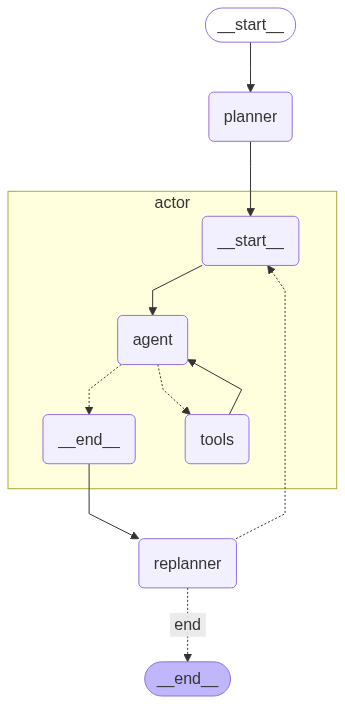

In [7]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Run

In [11]:
config = {"recursion_limit" : 50}
inputs = {
    "request" : "최근 발생한 이란-이스라엘 간 분쟁이 발생한 원인에 대해 설명해줘."
}
for event in app.stream(inputs, config=config, stream_mode="values"):
    for key, value in event.items(): print(key, value)
    print("==================="*20)

trajectory []
request 최근 발생한 이란-이스라엘 간 분쟁이 발생한 원인에 대해 설명해줘.
plan ['최근 뉴스 및 신뢰할 수 있는 출처를 통해 이란과 이스라엘 간 분쟁 관련 사건을 조사한다.', '분쟁의 역사적 배경을 파악하기 위해 과거 이란-이스라엘 관계 및 주요 갈등 요인을 검토한다.', '최근 분쟁의 발단이 된 특정 사건이나 발언이 무엇인지 확인한다.', '양국의 정치적, 군사적, 경제적 이해관계와 관련된 요인을 분석하여 분쟁의 원인을 도출한다.', '국제 사회의 반응 및 개입 여부를 조사하여 분쟁의 확산 가능성을 평가한다.', '수집한 정보를 바탕으로 이란-이스라엘 간 분쟁의 원인에 대한 종합적인 설명을 작성한다.']
trajectory []
request 최근 발생한 이란-이스라엘 간 분쟁이 발생한 원인에 대해 설명해줘.
plan ['최근 뉴스 및 신뢰할 수 있는 출처를 통해 이란과 이스라엘 간 분쟁 관련 사건을 조사한다.', '분쟁의 역사적 배경을 파악하기 위해 과거 이란-이스라엘 관계 및 주요 갈등 요인을 검토한다.', '최근 분쟁의 발단이 된 특정 사건이나 발언이 무엇인지 확인한다.', '양국의 정치적, 군사적, 경제적 이해관계와 관련된 요인을 분석하여 분쟁의 원인을 도출한다.', '국제 사회의 반응 및 개입 여부를 조사하여 분쟁의 확산 가능성을 평가한다.', '수집한 정보를 바탕으로 이란-이스라엘 간 분쟁의 원인에 대한 종합적인 설명을 작성한다.']
trajectory [('최근 뉴스 및 신뢰할 수 있는 출처를 통해 이란과 이스라엘 간 분쟁 관련 사건을 조사한다.', '최근 이란과 이스라엘 간의 분쟁에 대한 주요 뉴스는 다음과 같습니다:\n\n1. **이스라엘과 하마스 간의 휴전 협상**: 이스라엘과 하마스 간의 휴전 협상이 교착 상태에 빠져 있으며, 가자 지구의 상황이 위기에 처해 있습니다. 이스라엘은 인질이 석방되지 않으면 가자 지구와의 휴전을 종료할 것이라고 밝혔습니다. (출처: [BBC News 코리아](https:/

최근 이란-이스라엘 간 분쟁의 발단은 2023년 10월 7일, 가자 지구 기반의 무장 단체 하마스가 이스라엘 남부에 기습 공격을 감행한 사건으로 시작되었습니다. 이 공격 이후 레바논의 이란 대리 세력인 헤즈볼라가 이스라엘 북부를 공격하였고, 예멘 기반의 이란 대리 세력인 후티는 홍해에서 국제 선박에 대한 공격을 개시했습니다. 이러한 일련의 공격들은 중동의 위기를 심화시켰고, 이스라엘은 이에 대응하여 헤즈볼라와 하마스의 군 지도부를 대거 제거하는 등 군사적 대응을 강화했습니다.

이후 2025년 6월 13일, 이스라엘은 이란의 핵 프로그램을 해체하기 위한 목적으로 이란의 핵시설과 군사시설을 대규모로 공습하였고, 이로 인해 이란은 전쟁 상태를 선포하며 이스라엘에 대한 강력한 보복을 약속했습니다. 이스라엘의 공격은 미국이 제시한 60일간의 핵 협상 시한이 종료된 다음 날 이루어졌으며, 이스라엘은 이 전쟁이 이란 국민이 아닌 이란 정권을 상대로 한 것이라고 주장했습니다.

이러한 사건들이 최근 이란-이스라엘 분쟁의 주요 발단이 되었습니다. 또한, 이란과 이스라엘 간의 역사적 적대감과 지정학적, 이념적 갈등이 복합적으로 작용하여 분쟁이 심화되고 있습니다. 이란의 핵 개발과 이에 대한 이스라엘의 경계, 이란의 하마스 및 헤즈볼라 지원, 이스라엘의 팔레스타인 문제 등이 주요 갈등 요인으로 작용하고 있습니다.